### 작업개요
* 완성된 시각화 코드에서, 토크나이저와 사전 학습 모델을 변경하여 시각화 한다
* 파인튜닝 이후 시각화 결과의 변화를 관찰한다

In [1]:
# att.detach().numpy()
# # matplotlib에서 한글 표시
# # https://teddylee777.github.io/colab/colab-korean
# https://teddylee777.github.io/visualization/matplotlib-시각화-한글폰트적용
# !apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# # 설치한 뒤에 런타임 재시작이 필수

### Import

In [1]:
import os
import time
import datetime
import random
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
from sklearn.preprocessing import normalize

import torch
import wandb
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

/home/hdh/PycharmProjects/huggingface_bert/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Data

#### for finetune

In [2]:
# Load the dataset into a pandas dataframe.
df_train = pd.read_csv("data/h04w4/train_H04W4_220511.txt", delimiter='\t', dtype=str, header=0, names=['text', 'label'])
df_test = pd.read_csv("data/h04w4/test_H04W4_220511.txt", delimiter='\t', dtype=str, header=0, names=['text', 'label'])
# Get the lists of sentences and their labels.
sentences = df_train.text.values
labels = df_train.label.values.astype('int64')

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df_train.shape[0]))

# Display 10 random rows from the data.
# df_train.head(10)

Number of training sentences: 2,095



In [3]:
import wandb
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {

        'learning_rate': {
            'values': [ 5e-5, 3e-5, 2e-5]
        },
        'batch_size': {
            'values': [16, 32]
        },
        'epochs':{
            'values':[2, 3, 4]
        }
    }
}
sweep_defaults = {
    'learning_rate': 5e-5,
    'batch_size': 32,
    'epochs': 15
}

sweep_id = wandb.sweep(sweep_config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: 2psm2igq
Sweep URL: https://wandb.ai/sejongict/uncategorized/sweeps/2psm2igq


In [4]:
# aa0b8b5dcab973004277f569aea32d30c4fc1655

### Define Functions

In [5]:
def ret_model():

    model = BertForSequenceClassification.from_pretrained(
        "bert-base-multilingual-cased", 
        # cached_path='./',
        num_labels = 5, 
        output_attentions = True, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )
    return model

In [6]:
def ret_optim(model):
    print('Learning_rate = ',wandb.config.learning_rate )
    optimizer = AdamW(model.parameters(),
                      lr = wandb.config.learning_rate, 
                      eps = 1e-8 
                    )
    return optimizer

In [7]:
def ret_scheduler(train_dataloader,optimizer):
    epochs = wandb.config.epochs
    print('epochs =>', epochs)
    # Total number of training steps is [number of batches] x [number of epochs]. 
    # (Note that this is not the same as the number of training samples).
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    return scheduler

In [8]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [9]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
def train(train_dataloader,validation_dataloader):
    wandb.init(config=sweep_defaults)
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ret_model()
    model.to(device)
    #wandb.init(config=sweep_defaults)
#     train_dataloader,validation_dataloader = ret_dataloader(train_dataset, val_dataset)
    optimizer = ret_optim(model)
    scheduler = ret_scheduler(train_dataloader,optimizer)

    #print("config ",wandb.config.learning_rate, "\n",wandb.config)
    seed_val = 42
   
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    #torch.cuda.manual_seed_all(seed_val)

    # We'll store a number of quantities such as training and validation loss, 
    # validation accuracy, and timings.
    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()
    epochs = wandb.config.epochs
    # For each epoch...
    for epoch_i in range(0, epochs):
        
        # ========================================
        #               Training
        # ========================================
        
        # Perform one full pass over the training set.

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0

        # Put the model into training mode. Don't be mislead--the call to 
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)
                
                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the 
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because 
            # accumulating the gradients is "convenient while training RNNs". 
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()        

            # Perform a forward pass (evaluate the model on this training batch).
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # It returns different numbers of parameters depending on what arguments
            # arge given and what flags are set. For our useage here, it returns
            # the loss (because we provided labels) and the "logits"--the model
            # outputs prior to activation.
            outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=b_labels)
            loss, logits = outputs['loss'], outputs['logits']
            wandb.log({'train_batch_loss':loss.item()})
            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.
            total_train_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            
        
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        wandb.log({'avg_train_loss':avg_train_loss})

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))
            
        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables 
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:
            
            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using 
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].cuda()
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        

                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # Get the "logits" output by the model. The "logits" are the output
                # values prior to applying an activation function like the softmax.
                outputs = model(b_input_ids, 
                                      token_type_ids=None, 
                                      attention_mask=b_input_mask,
                                      labels=b_labels)
                loss, logits = outputs['loss'], outputs['logits']
#                 print(outputs)
            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)
            

        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        
        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)
        wandb.log({'val_accuracy':avg_val_accuracy,'avg_val_loss':avg_val_loss})
        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

    torch.save(model.state_dict(), os.path.join(PATH, 'bert-base-multilingual-cased.pt'))


In [10]:
# WANDB PARAMETER
def ret_dataloader(train_dataset, val_dataset):
    batch_size = wandb.config.batch_size
    print('batch_size = ', batch_size)
    train_dataloader = DataLoader(
                train_dataset,  # The training samples.
                sampler = RandomSampler(train_dataset), # Select batches randomly
                batch_size = batch_size # Trains with this batch size.
            )

    validation_dataloader = DataLoader(
                val_dataset, # The validation samples.
                sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                batch_size = batch_size # Evaluate with this batch size.
            )
    return train_dataloader,validation_dataloader

In [11]:
def create_data(sentences, tokenizer, max_length=128):
    # Load the dataset into a pandas dataframe.
    df_train = pd.read_csv("data/h04w4/train_H04W4_220511.txt", delimiter='\t', dtype=str, header=0, names=['text', 'label'])
    df_test = pd.read_csv("data/h04w4/test_H04W4_220511.txt", delimiter='\t', dtype=str, header=0, names=['text', 'label'])
    # Get the lists of sentences and their labels.
    sentences = df_train.text.values
    labels = df_train.label.values.astype('int64')

    # Report the number of sentences.
    print('Number of training sentences: {:,}\n'.format(df_train.shape[0]))

    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_length,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            truncation = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])
        # Convert the lists into tensors.
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    # Print sentence 0, now as a list of IDs.
    # print('Original: ', sentences[0])
    # print('Token IDs:', input_ids[0])
    
    # Combine the training inputs into a TensorDataset.
    dataset = TensorDataset(input_ids, attention_masks, labels)

    # Create a 90-10 train-validation split.

    # Calculate the number of samples to include in each set.
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size

    # Divide the dataset by randomly selecting samples.
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    print('{:>5,} training samples'.format(train_size))
    print('{:>5,} validation samples'.format(val_size))
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    wandb.init(config=sweep_defaults)
    train_dataloader,validation_dataloader = ret_dataloader(train_dataset, val_dataset)
    return train_dataloader,validation_dataloader

In [12]:
def get_att(sample, tokenizer, model, max_length=128):
    encoded_sample = tokenizer.encode_plus(
        sample,                      # Sentence to encode.
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = max_length,           # Pad & truncate all sentences.
        pad_to_max_length = False,
        truncation = True,
        return_attention_mask = True,   # Construct attn. masks.
        return_tensors = 'pt',     # Return pytorch tensors.
        )
    sample_ids = encoded_sample['input_ids']
    sample_masks = encoded_sample['attention_mask']

    b_input_ids = torch.cat([sample_ids]).to(device)
    b_input_mask = torch.cat([sample_masks]).to(device)
    # b_labels = torch.cat(sample_tok[2]).to(device)

#     b_input_ids, len(b_input_ids[0]), b_input_mask, len(b_input_mask[0])
    # tokenizer.vocab
    sampleid = sample_ids[0].detach().numpy()
    # tok = tokenizer.tokenize(sample)
    tok = tokenizer.convert_ids_to_tokens(sampleid)

    model.zero_grad()
    outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask,)
    # print(outputs['attentions'])  # loss, logits, hidden_states=None, attentions 순으로 출력
    attentions = torch.cat(outputs['attentions']).to('cpu')
    #     attentions.shape  # layer, batch_size (squeezed by torch.cat), num_heads, sequence_length, sequence_length)
    attentions = attentions.permute(2,1,0,3)
    layers = len(attentions[0][0])
    heads = len(attentions[0])
    seqlen = len(attentions)
    #     layers,heads,seqlen
    return attentions

In [13]:
def get_tok(sample, tokenizer, model, max_length=128):
    encoded_sample = tokenizer.encode_plus(
        sample,                      # Sentence to encode.
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = max_length,           # Pad & truncate all sentences.
        pad_to_max_length = False,
        truncation = True,
        return_attention_mask = True,   # Construct attn. masks.
        return_tensors = 'pt',     # Return pytorch tensors.
        )
    sample_ids = encoded_sample['input_ids']
    sample_masks = encoded_sample['attention_mask']

    b_input_ids = torch.cat([sample_ids]).to(device)
    b_input_mask = torch.cat([sample_masks]).to(device)
    # b_labels = torch.cat(sample_tok[2]).to(device)

#     b_input_ids, len(b_input_ids[0]), b_input_mask, len(b_input_mask[0])
    # tokenizer.vocab
    sampleid = sample_ids[0].detach().numpy()
    # tok = tokenizer.tokenize(sample)
    tok = tokenizer.convert_ids_to_tokens(sampleid)
    return tok

In [14]:
max_length = 128

### Finetune with bert-base-multilingual-cased tokenizer

In [15]:
tokenizer = BertTokenizer.from_pretrained(
        'bert-base-multilingual-cased', clean_text=False, do_lower_case=True, strip_accents=False, handle_chinese_chars=True)
# tok = tokenizer.tokenize('제1 채널 구간동안 주변 차량 노드로부터 비컨 메시지를 수신하는 단계')
# print(len(tok), tok)

In [16]:
train_dataloader, validation_dataloader = create_data(sentences, tokenizer, max_length=128)

Number of training sentences: 2,095



/home/hdh/PycharmProjects/huggingface_bert/venv/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2263: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


1,885 training samples
  210 validation samples


wandb: Currently logged in as: scor9947 (sejongict). Use `wandb login --relogin` to force relogin


batch_size =  32


### Load Pre-trained BERT model

### Extract Attentions from bert-base-multilingual-cased

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)
sample = '휴대형 디지털 비디오 방송 방통융합 서비스 시스템에서 이동성을 지원하는 방법 및 장치'
# sample = '제1 채널 구간동안 주변 차량 노드로부터 비컨 메시지를 수신하는 단계'
# sample = 'UV 광원을 사용한 보안 인쇄물의 위변조 확인 방법에 있어서,피인쇄물을 준비하는 단계;UV 광원을 상기 제1영역 및 제2영역에 조사하여, 상기 제1영역은 제1색으로 발광하고, 제2영역은 제2색으로 발광하는 다색 발광 단계;UV 광원의 조사를 중지하는 단계; 및UV 조사가 중지된 이후, 상기 제1영역의 발광은 사라지고, 동시에 제2영역은 소정 시간 동안 제3색을 발광하고, 이후 제3색이 사라지거나, 제4색으로 일정 시간 동안 발광하는 색변환 단계;를 포함하고, 상기 피인쇄물은, 형광체을 포함하는 제1 보안 잉크를 사용하여 상기 피인쇄물의 표면에 제1영역이 인쇄되고, 형광체와 인광체을 포함하는 제2 보안 잉크를 사용하여 상기 피인쇄물의 표면에 제2영역이 인쇄된 것인, UV 광원을 사용한 보안 인쇄물의 위변조 확인 방법.'

In [18]:
model = ret_model()
model.to(device)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [19]:
# # multilingual tokenizer, 
# attentions = get_att(sample, tokenizer, model, max_length=128)
# layers = len(attentions[0][0])
# heads = len(attentions[0])
# seqlen = len(attentions)

### Fine-tuning

In [20]:
PATH = "h04w4_trained_model(base tokenizer)"
# PATH = "h04w4_trained_model/bert-base-multilingual-cased.pt"

In [21]:
# train(train_dataloader,validation_dataloader)

In [22]:
# wandb.agent(sweep_id, function=train)

### Extract Attention

In [23]:
att_concat = []
layers_concat = []
heads_concat = []
seqlen_concat = []

In [24]:
# case01 : base tokenizer, bert-base-multilingual-cased
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", 
    # cached_path='./',
    num_labels = 5, 
    output_attentions = True, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
model.to(device)
# multilingual tokenizer, 
attentions = get_att(sample, tokenizer, model, max_length=128)
att_concat.append(attentions)
layers_concat.append(len(attentions[0][0]))
heads_concat.append(len(attentions[0]))
seqlen_concat.append(len(attentions))

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [25]:
# case02 : base tokenizer, finetuned
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", 
    # cached_path='./',
    num_labels = 5, 
    output_attentions = True, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
chkpoint = torch.load('h04w4_trained_model(base tokenizer)/bert-base-multilingual-cased.pt')
model.load_state_dict(chkpoint)
model.to(device)
# multilingual tokenizer, 
attentions = get_att(sample, tokenizer, model, max_length=128)
att_concat.append(attentions)
layers_concat.append(len(attentions[0][0]))
heads_concat.append(len(attentions[0]))
seqlen_concat.append(len(attentions))

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [26]:
# case03 : trained tokenizer, bert-base-multilingual-cased
tokenizer1 = BertTokenizer.from_pretrained(
        'h04w4_trained_model', clean_text=False, do_lower_case=True, strip_accents=False, handle_chinese_chars=True)
# tok = tokenizer.tokenize('제1 채널 구간동안 주변 차량 노드로부터 비컨 메시지를 수신하는 단계')
# print(len(tok), tok)
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", 
    # cached_path='./',
    num_labels = 5, 
    output_attentions = True, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
model.to(device)
# multilingual tokenizer, 
attentions = get_att(sample, tokenizer1, model, max_length=128)
att_concat.append(attentions)
layers_concat.append(len(attentions[0][0]))
heads_concat.append(len(attentions[0]))
seqlen_concat.append(len(attentions))

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [27]:
# case04 : trained tokenizer, finetuned
tokenizer1 = BertTokenizer.from_pretrained(
        'h04w4_trained_model', clean_text=False, do_lower_case=True, strip_accents=False, handle_chinese_chars=True)
# tok = tokenizer.tokenize('제1 채널 구간동안 주변 차량 노드로부터 비컨 메시지를 수신하는 단계')
# print(len(tok), tok)
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", 
    # cached_path='./',
    num_labels = 5, 
    output_attentions = True, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
chkpoint = torch.load('h04w4_trained_model/bert-base-multilingual-cased.pt')
model.load_state_dict(chkpoint)
model.to(device)
# multilingual tokenizer, 
attentions = get_att(sample, tokenizer1, model, max_length=128)
att_concat.append(attentions)
layers_concat.append(len(attentions[0][0]))
heads_concat.append(len(attentions[0]))
seqlen_concat.append(len(attentions))

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [28]:
len(att_concat), att_concat[0].shape

(4, torch.Size([30, 12, 12, 30]))

### Visualization Attention

In [29]:
# 시각화 과정에서 수치 표시
# https://collocationvoca.tistory.com/13

In [30]:
matplotlib.matplotlib_fname()

'/home/hdh/PycharmProjects/huggingface_bert/venv/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'

In [31]:
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothic'
# plt.rcParams['font.family'] = 'Malgun Gothic'

#### 참고
* https://colab.research.google.com/github/PyTorchKorea/tutorials-kr/blob/master/docs/_downloads/67710f3d40ca3863323ce02dddbf8618/save_load_across_devices.ipynb#scrollTo=FySKcUVQig5q

In [32]:
tok = get_tok(sample, tokenizer, model, max_length=128)

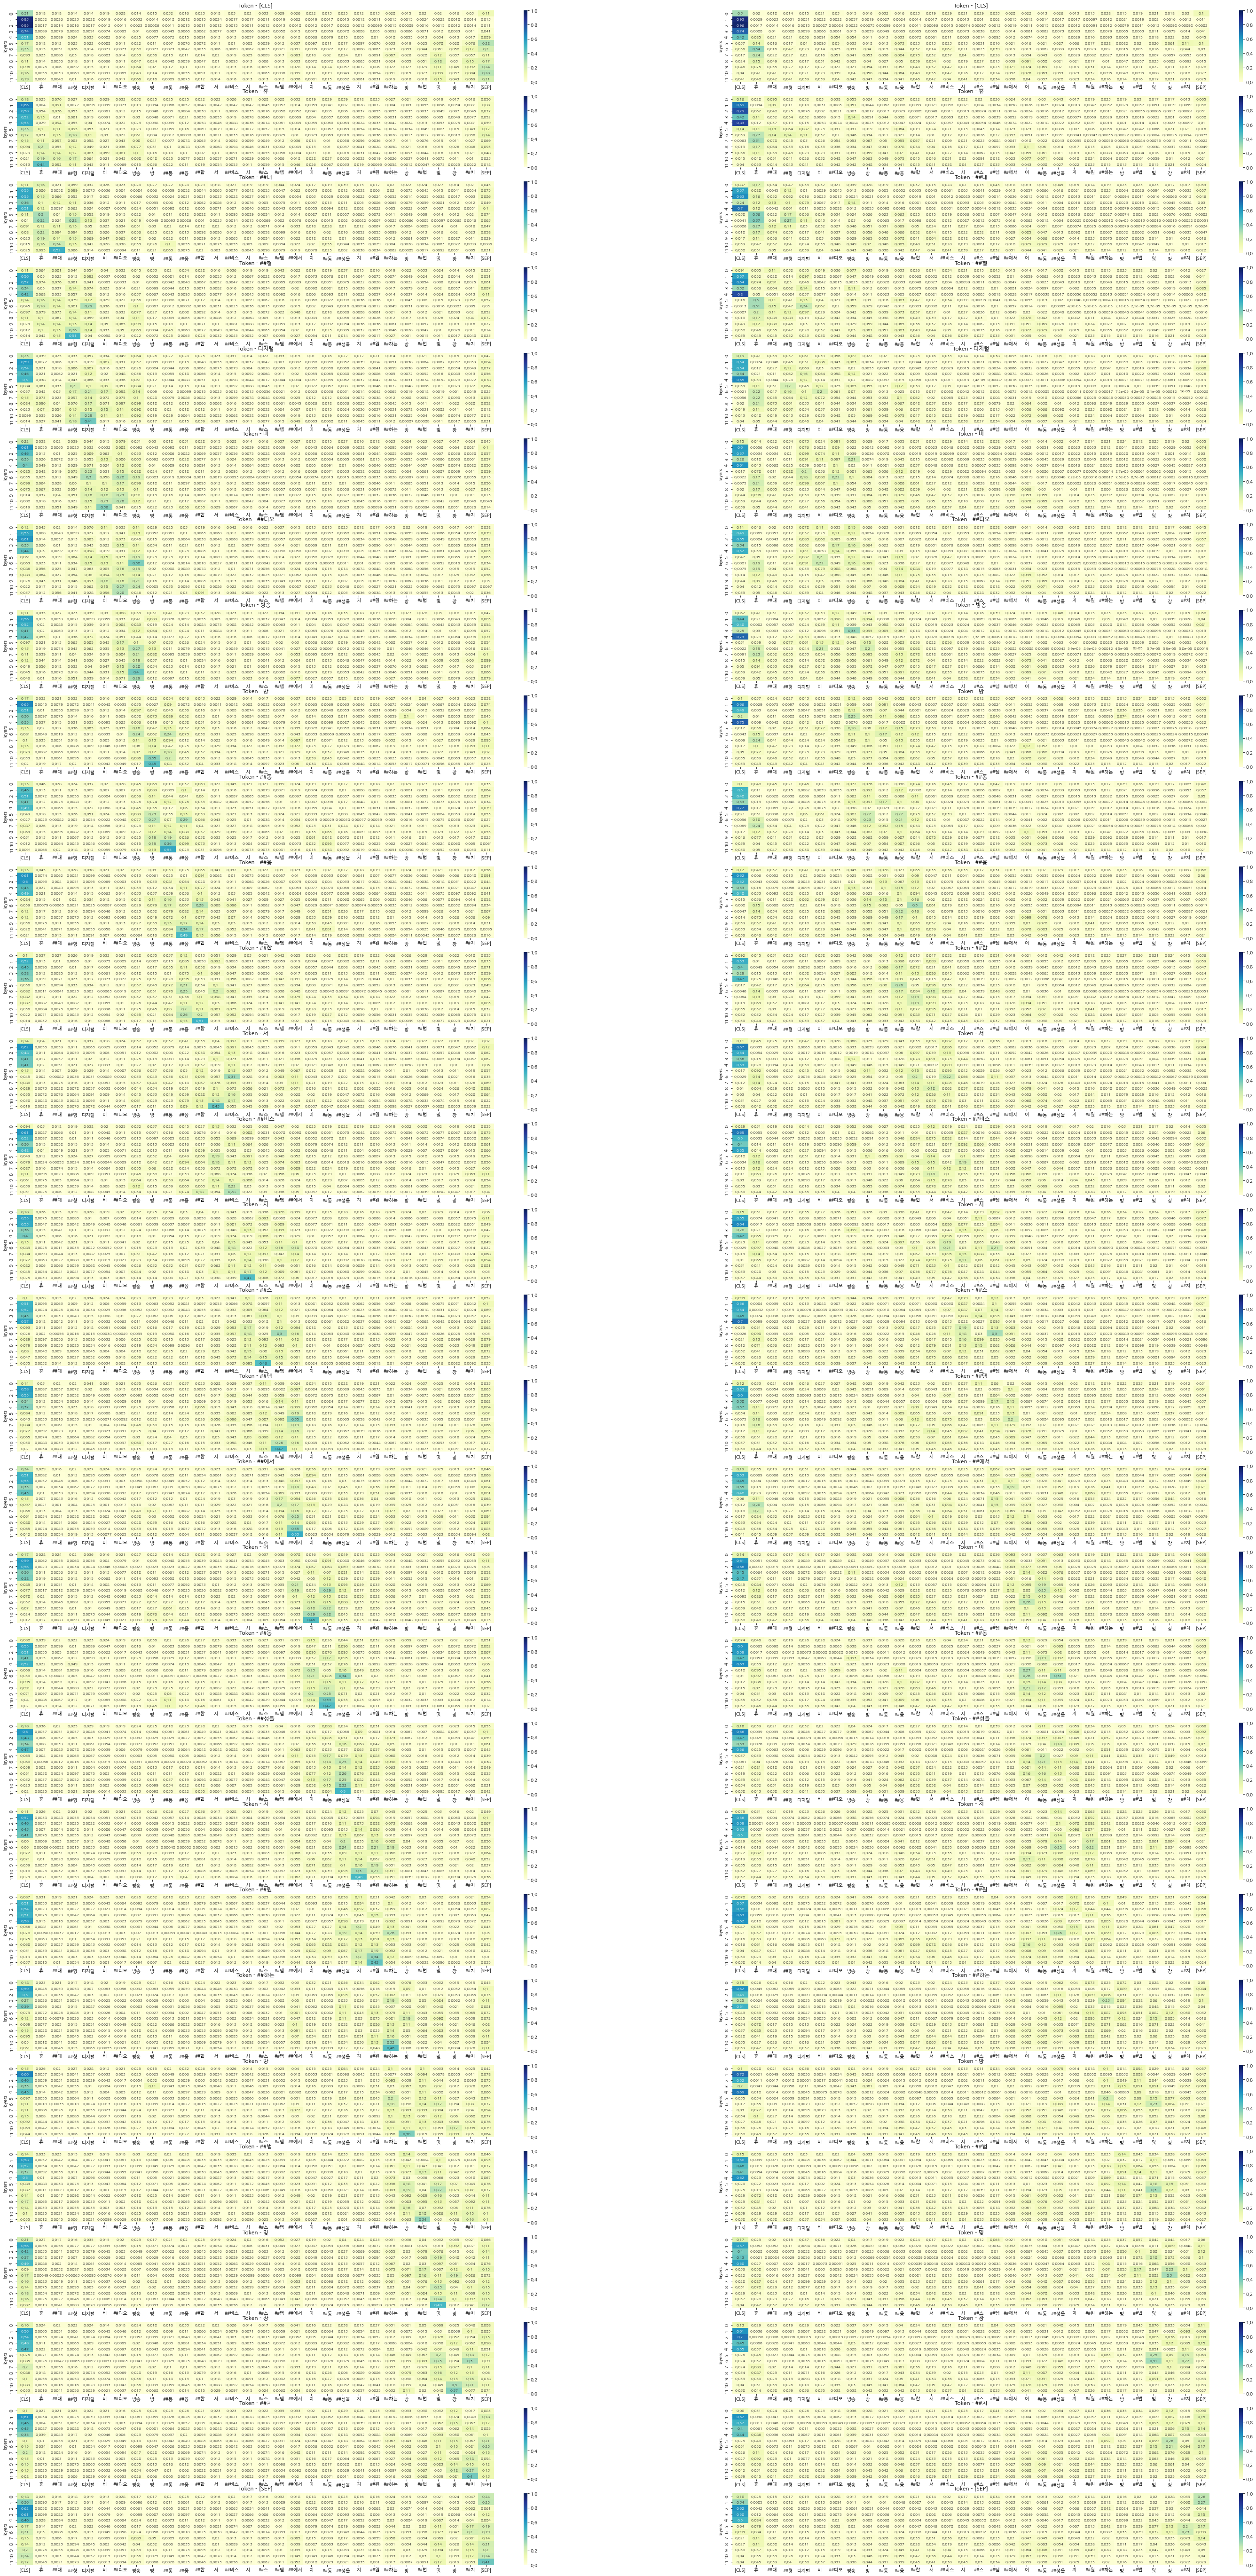

In [37]:
attentions = att_concat[0].detach().numpy()
finetuned_attentions = att_concat[1].detach().numpy()

cols = 2
rows = len(attentions)
fig, axes = plt.subplots(rows, cols, figsize = (50,100))
# fig, (axes1, axes2) = plt.subplots(rows, cols, figsize = (10,50))
# axes = axes.flat
for p_pos in range(finetuned_attentions.shape[0]):
    attentions_pos = attentions[p_pos]
    avg_attention = attentions_pos.mean(axis = 0)
    finetuned_attentions_pos = finetuned_attentions[p_pos]
    finetuned_avg_attention = finetuned_attentions_pos.mean(axis = 0)

    sns.heatmap(avg_attention, ax = axes[p_pos, 0], 
                vmin = 0, vmax = 1, xticklabels= tok, annot=True, annot_kws={'size':8}, cmap='YlGnBu')
    sns.heatmap(finetuned_avg_attention, ax = axes[p_pos, 1], 
                vmin = 0, vmax = 1, xticklabels= tok, annot=True, annot_kws={'size':8}, cmap='YlGnBu')
    axes[p_pos,0].set_title(f'Token - {tok[p_pos]}' )
    axes[p_pos,0].set_ylabel('layers')
    axes[p_pos,1].set_title(f'Token - {tok[p_pos]}' )
    axes[p_pos,1].set_ylabel('layers')
plt.savefig(f'result_image/att_compare_untrained_tokenizer.png', transparent=False)

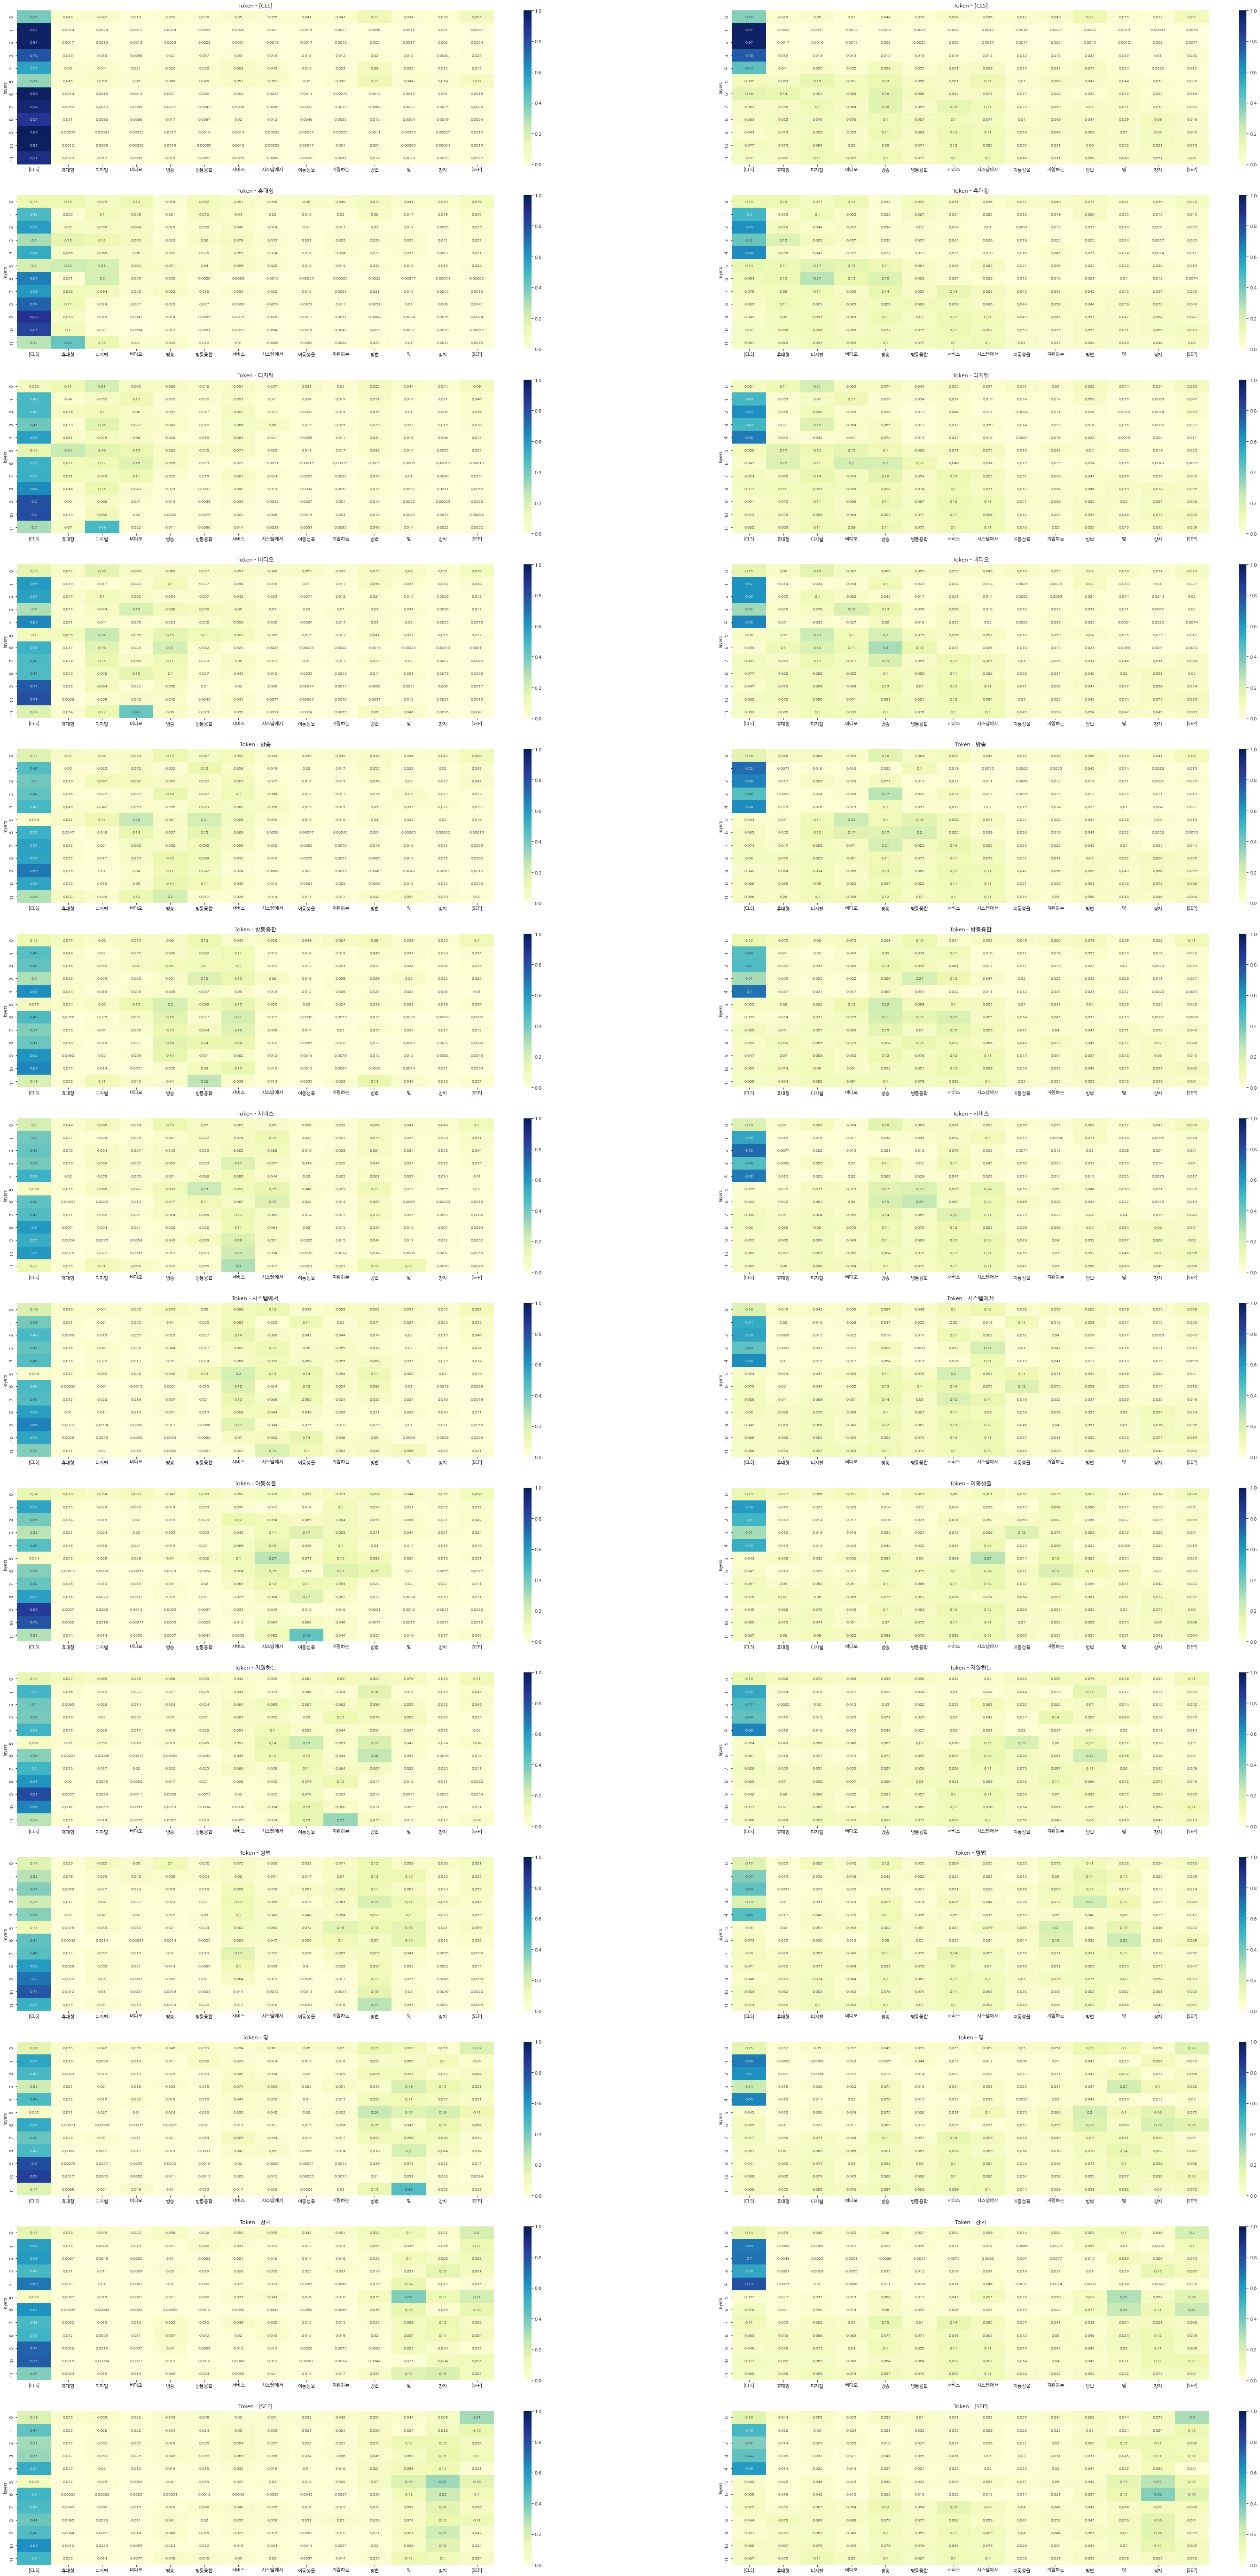

In [39]:
tok1 = get_tok(sample, tokenizer1, model, max_length=128)
attentions = att_concat[2].detach().numpy()
finetuned_attentions = att_concat[3].detach().numpy()

cols = 2
rows = len(attentions)
fig, axes = plt.subplots(rows, cols, figsize = (50,100))
# fig, (axes1, axes2) = plt.subplots(rows, cols, figsize = (10,50))
# axes = axes.flat
for p_pos in range(finetuned_attentions.shape[0]):
    attentions_pos = attentions[p_pos]
    avg_attention = attentions_pos.mean(axis = 0)
    finetuned_attentions_pos = finetuned_attentions[p_pos]
    finetuned_avg_attention = finetuned_attentions_pos.mean(axis = 0)

    sns.heatmap(avg_attention, ax = axes[p_pos, 0], 
                vmin = 0, vmax = 1, xticklabels= tok1, annot=True, annot_kws={'size':8}, cmap='YlGnBu')
    sns.heatmap(finetuned_avg_attention, ax = axes[p_pos, 1], 
                vmin = 0, vmax = 1, xticklabels= tok1, annot=True, annot_kws={'size':8}, cmap='YlGnBu')
    axes[p_pos,0].set_title(f'Token - {tok1[p_pos]}' )
    axes[p_pos,0].set_ylabel('layers')
    axes[p_pos,1].set_title(f'Token - {tok1[p_pos]}' )
    axes[p_pos,1].set_ylabel('layers')
plt.savefig(f'result_image/att_compare_trained_tokenizer.png', transparent=False)

(30, 30)


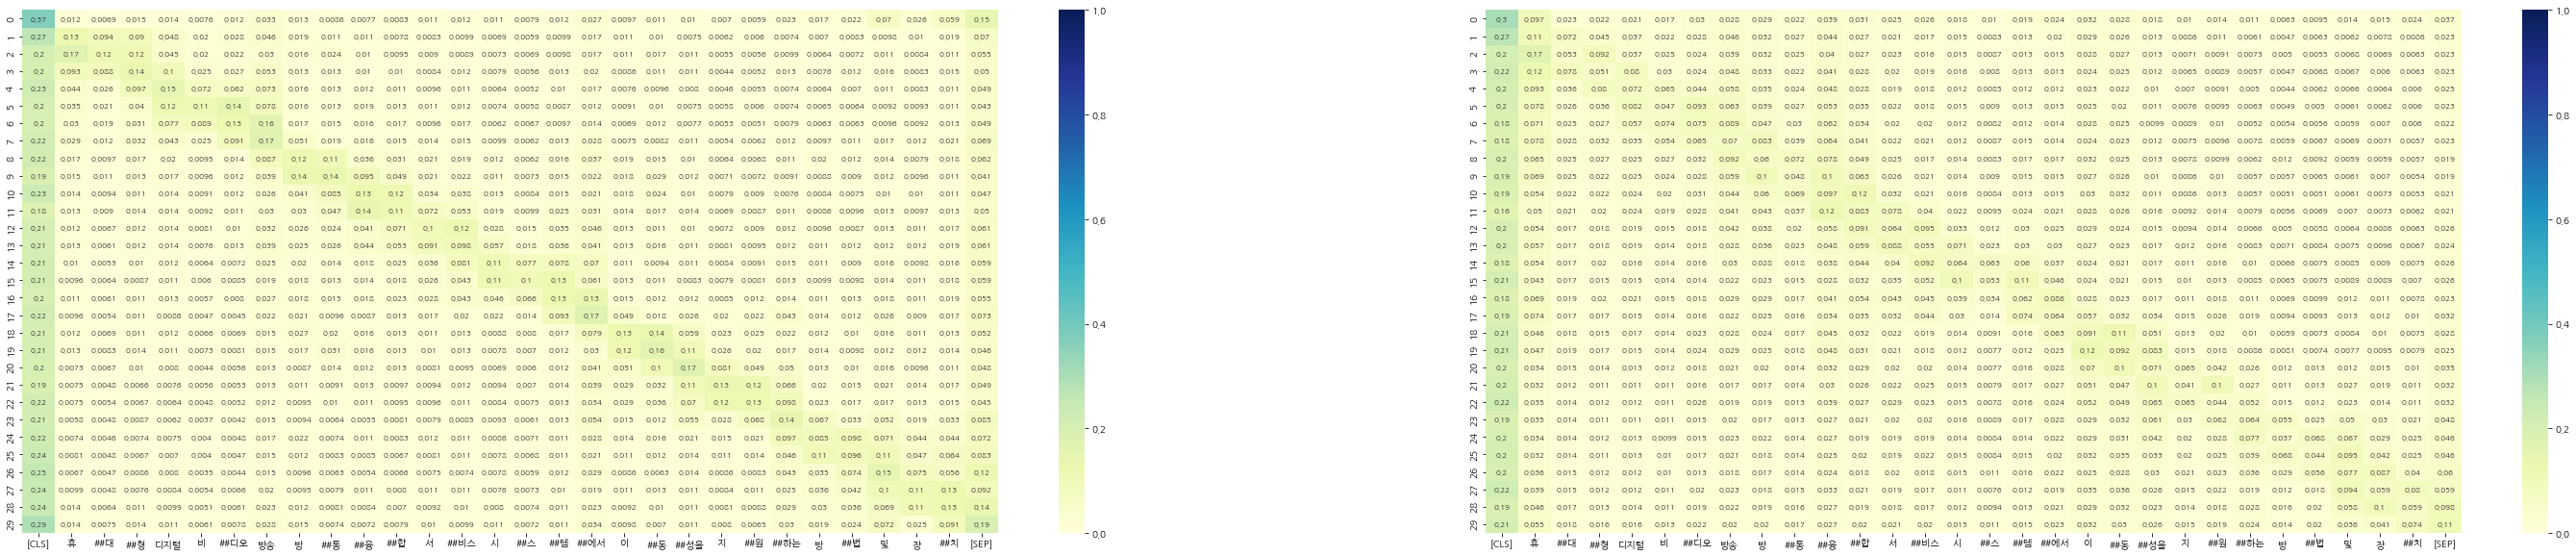

In [40]:
# 평균을 내보자

attentions = att_concat[0].detach().numpy()
finetuned_attentions = att_concat[1].detach().numpy()
# print(attentions.shape)
cols = 2
rows = 1
fig, axes = plt.subplots(rows, cols, figsize = (50,10))

avg_attention = attentions.mean(axis = 1).mean(axis = 1)
# avg_attention = np.argmax(attentions, axis=1)
# avg_attention = avg_attention.sum(axis=1).sum(axis=1)
print(avg_attention.shape)
finetuned_avg_attention = finetuned_attentions.mean(axis = 1).mean(axis = 1)

sns.heatmap(avg_attention, ax = axes[0], 
            vmin = 0, vmax = 1, xticklabels= tok, annot=True, annot_kws={'size':8}, cmap='YlGnBu')
sns.heatmap(finetuned_avg_attention, ax = axes[1], 
            vmin = 0, vmax = 1, xticklabels= tok, annot=True, annot_kws={'size':8}, cmap='YlGnBu')
plt.savefig('result_image/average_att_compare_untrained_tokenizer.png', transparent=False)
# See average attention for token

(30, 12, 12, 30)
(28, 28)


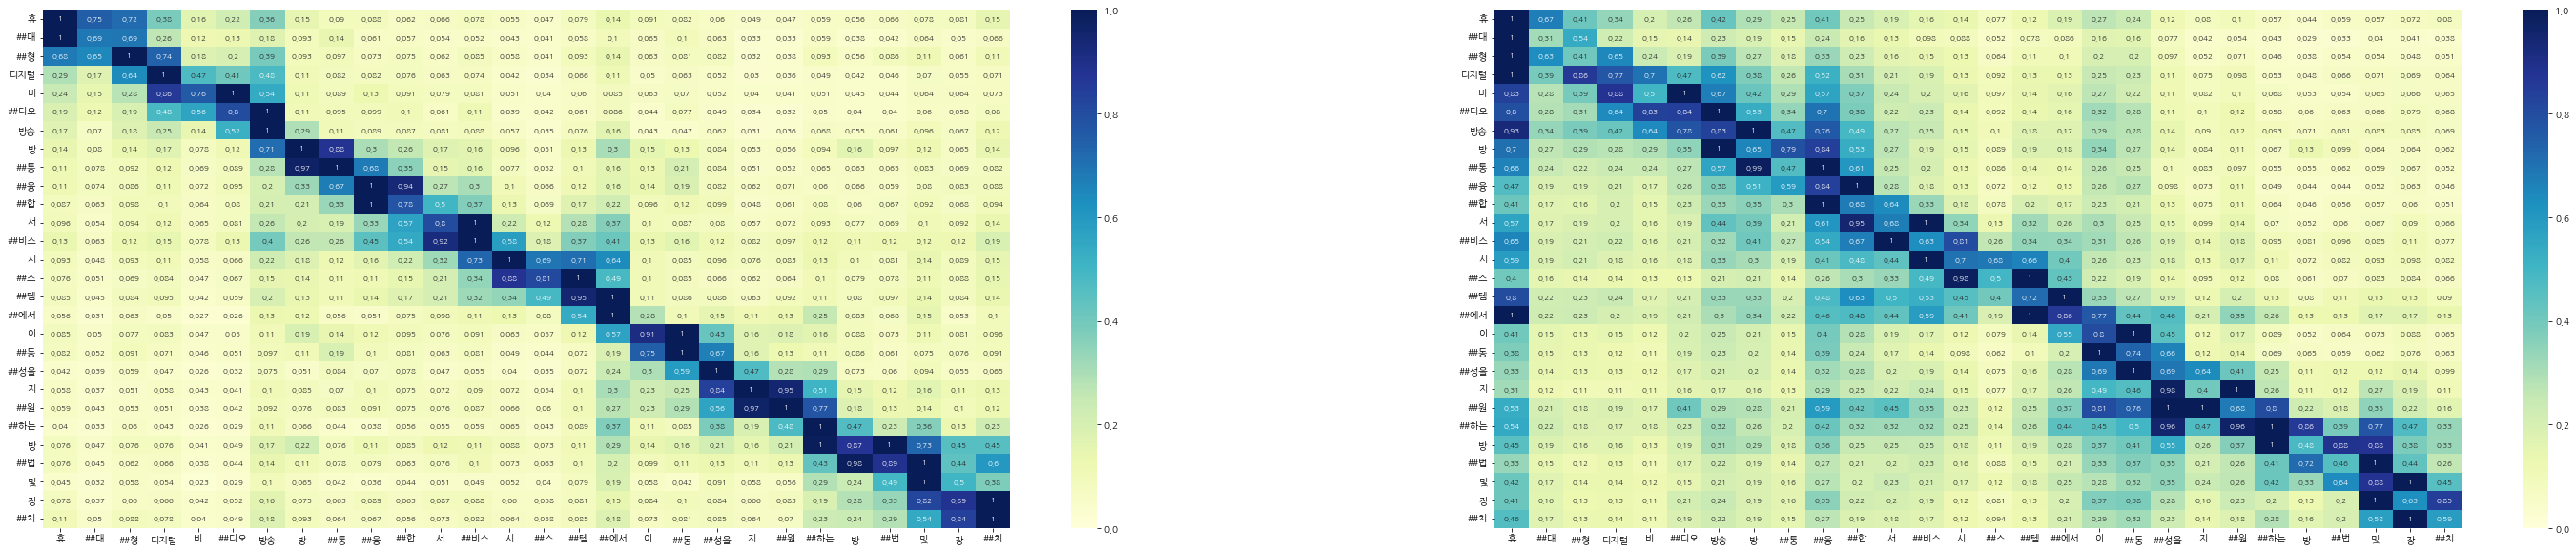

In [79]:
# att를 정규화해보자

attentions = att_concat[0].detach().numpy()
finetuned_attentions = att_concat[1].detach().numpy()
print(attentions.shape)
cols = 2
rows = 1
fig, axes = plt.subplots(rows, cols, figsize = (50,10))

avg_attention = attentions.mean(axis = 1).mean(axis = 1)
avg_attention = normalize(avg_attention[1:-1,1:-1], axis=1, norm='max')
print(avg_attention.shape)
finetuned_avg_attention = finetuned_attentions.mean(axis = 1).mean(axis = 1)
finetuned_avg_attention = normalize(finetuned_avg_attention[1:-1,1:-1], axis=1, norm='max')

sns.heatmap(avg_attention, ax = axes[0], 
            vmin = 0, vmax = 1, xticklabels= tok[1:-1], yticklabels = tok[1:-1], annot=True, annot_kws={'size':8}, cmap='YlGnBu')
sns.heatmap(finetuned_avg_attention, ax = axes[1], 
            vmin = 0, vmax = 1, xticklabels= tok[1:-1], yticklabels = tok[1:-1], annot=True, annot_kws={'size':8}, cmap='YlGnBu')
plt.savefig('result_image/average_att_compare_untrained_tokenizer.png', transparent=False)
# See average attention for token

(14, 12, 12, 14)
(12, 12)


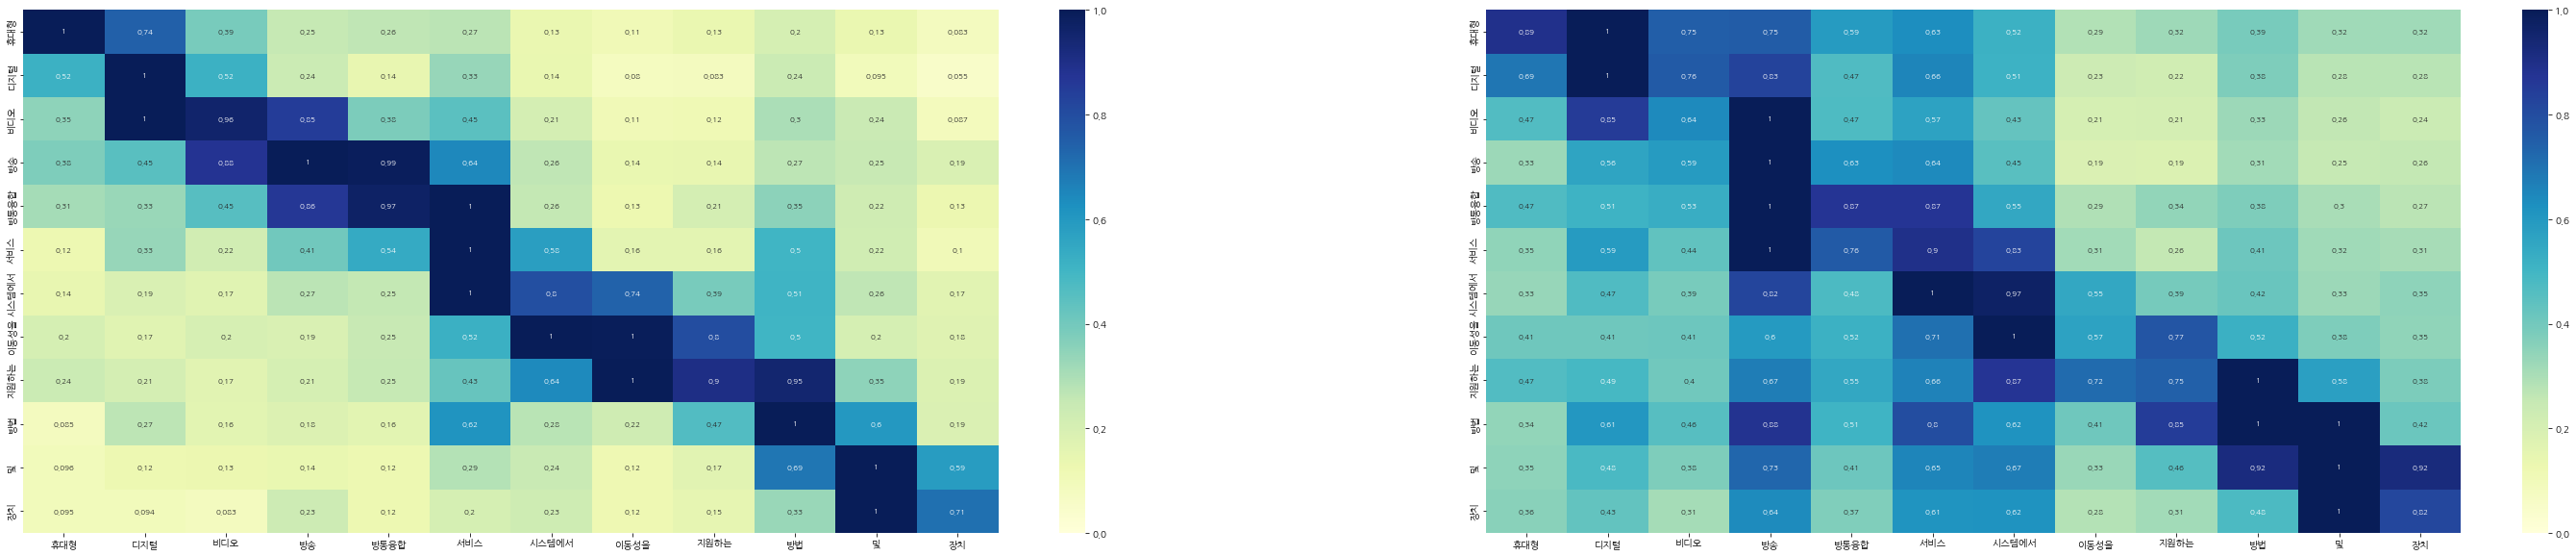

In [82]:
# att를 정규화해보자

attentions = att_concat[2].detach().numpy()
finetuned_attentions = att_concat[3].detach().numpy()
print(attentions.shape)
cols = 2
rows = 1
fig, axes = plt.subplots(rows, cols, figsize = (50,10))

avg_attention = attentions.mean(axis = 1).mean(axis = 1)
avg_attention = normalize(avg_attention[1:-1,1:-1], axis=1, norm='max')
print(avg_attention.shape)
finetuned_avg_attention = finetuned_attentions.mean(axis = 1).mean(axis = 1)
finetuned_avg_attention = normalize(finetuned_avg_attention[1:-1,1:-1], axis=1, norm='max')

sns.heatmap(avg_attention, ax = axes[0], 
            vmin = 0, vmax = 1, xticklabels= tok1[1:-1], yticklabels = tok1[1:-1], annot=True, annot_kws={'size':8}, cmap='YlGnBu')
sns.heatmap(finetuned_avg_attention, ax = axes[1], 
            vmin = 0, vmax = 1, xticklabels= tok1[1:-1], yticklabels = tok1[1:-1], annot=True, annot_kws={'size':8}, cmap='YlGnBu')
plt.savefig('result_image/average_att_compare_trained_tokenizer.png', transparent=False)
# See average attention for token

In [ ]:
# # att를 정규화해보자
# fig, axes = plt.subplots(seqlen, 1, figsize = (20,10))
# axes = axes.flat
# for i, attentions_pos in enumerate(attentions):
#     # See average attention for token
#     avg_attention = attentions_pos.mean(dim = 0)
#     # fig, axes = plt.subplots(1, cols, figsize = (20,10))
#     # att = avg_attention.detach().numpy().mean(axis=0).reshape(1,13)
#     att = normalize(avg_attention.detach().numpy().mean(axis=0)[1:-1].reshape(1,-1), norm='max')
#     sns.heatmap(att, ax = axes[i],
#                 vmin = 0, vmax = 1, xticklabels= tok, annot=True, annot_kws={'size':8}, cmap='YlGnBu')
#     # plt.savefig(f'/content/gdrive/MyDrive/Study/세종ICT/saved_model/h04w4/average_att_finetunedmodel/{i}_{tok[i]}_average_att.png')


In [65]:
# display.Image(f'result_image/att_compare_untrained_tokenizer.png')

In [66]:
# display.Image(f'result_image/att_compare_trained_tokenizer.png')

In [44]:
# 출처 https://wikidocs.net/50739

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
# from konlpy.tag import Okt

In [45]:
wv_train = pd.DataFrame(sentences, columns=['text'])

In [47]:
tokenized_data = []
for sentence in wv_train['text']:
    tokenized_sentence = get_tok(sentence, tokenizer, model, max_length=1024)
    # tokenized_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(tokenized_sentence)

tokenized_data1 = []
for sentence in wv_train['text']:
    tokenized_sentence1 = get_tok(sentence, tokenizer1, model, max_length=1024)
    # tokenized_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data1.append(tokenized_sentence1)

# tok = get_tok(sample, tokenizer, model, max_length=128)
# tok1 = get_tok(sample, tokenizer1, model, max_length=128)

최대 길이 : 1024
평균 길이 : 224.4400954653938


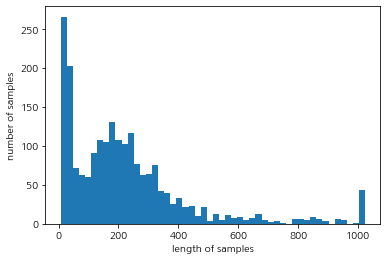

In [48]:
print('최대 길이 :',max(len(sent) for sent in tokenized_data))
print('평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(sent) for sent in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

최대 길이 : 1024
평균 길이 : 119.7379474940334


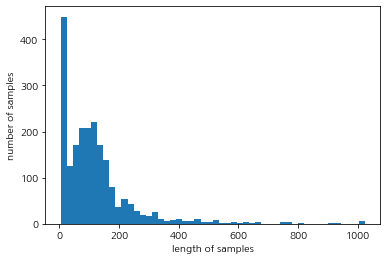

In [83]:
print('최대 길이 :',max(len(sent) for sent in tokenized_data1))
print('평균 길이 :',sum(map(len, tokenized_data1))/len(tokenized_data1))
plt.hist([len(sent) for sent in tokenized_data1], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [52]:
### 학습시키기

from gensim.models import Word2Vec

wv_model = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 5, min_count = 5, workers = 4, sg = 0)
wv_model1 = Word2Vec(sentences = tokenized_data1, vector_size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

### 오류시 해결 https://taepseon.tistory.com/165

In [56]:
print(wv_model.wv.most_similar("통신"))
print(wv_model1.wv.most_similar("통신"))

KeyError: "Key '통신' not present in vocabulary"

In [57]:
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
print('Imported Successfully!')

Imported Successfully!


<AxesSubplot:>

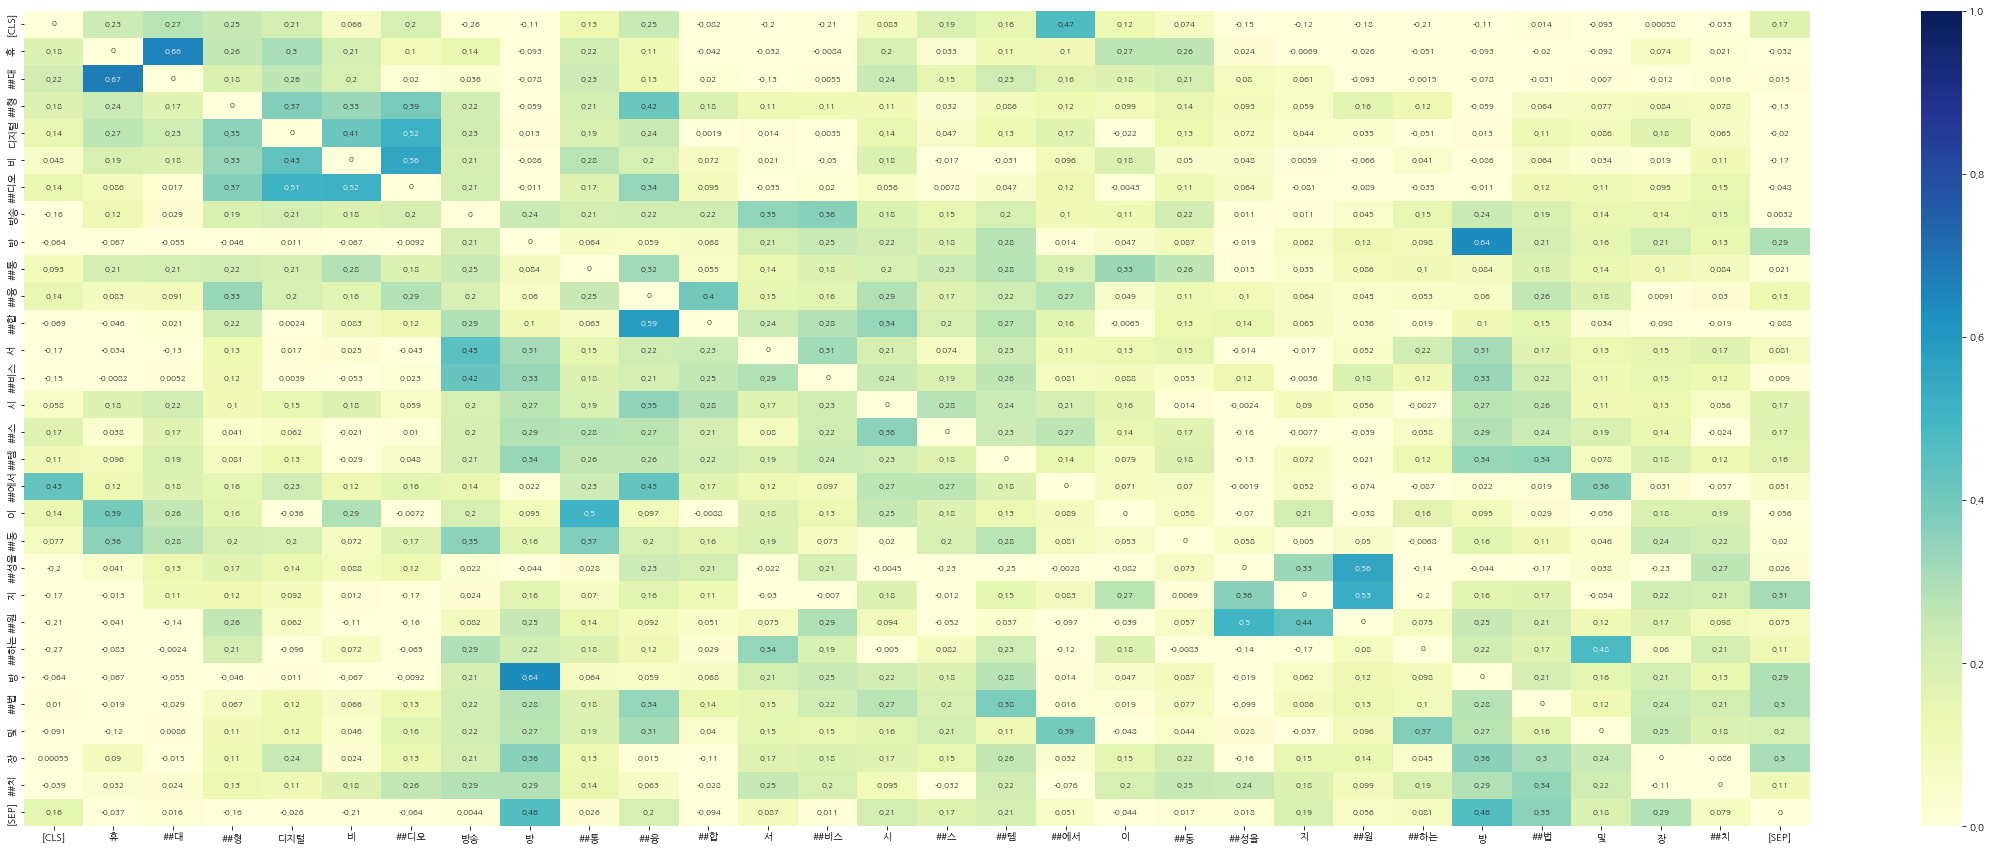

In [64]:
tok_sim = np.zeros((len(tok), len(tok)))
for i, w in enumerate(tok):
    for j, w1 in enumerate(tok):
        # print(cosine_similarity([wv_model.wv[w]], [wv_model.wv[w1]]))
        if i != j:
            tok_sim[i][j] = cosine_similarity([wv_model.wv[w]], [wv_model.wv[w1]])[0][0]

tok_sim = normalize(tok_sim, axis=1, norm='l2')
# print(tok_sim)
fig, axes = plt.subplots(1, 1, figsize = (40,15))
sns.heatmap(tok_sim, 
            vmin = 0, vmax = 1, xticklabels= tok, yticklabels = tok, annot=True, annot_kws={'size':8}, cmap='YlGnBu')
# sns.heatmap(finetuned_avg_attention, ax = axes[1], 
            # vmin = 0, vmax = 1, xticklabels= tok, yticklabels = tok, annot=True, annot_kws={'size':8}, cmap='YlGnBu')


<AxesSubplot:>

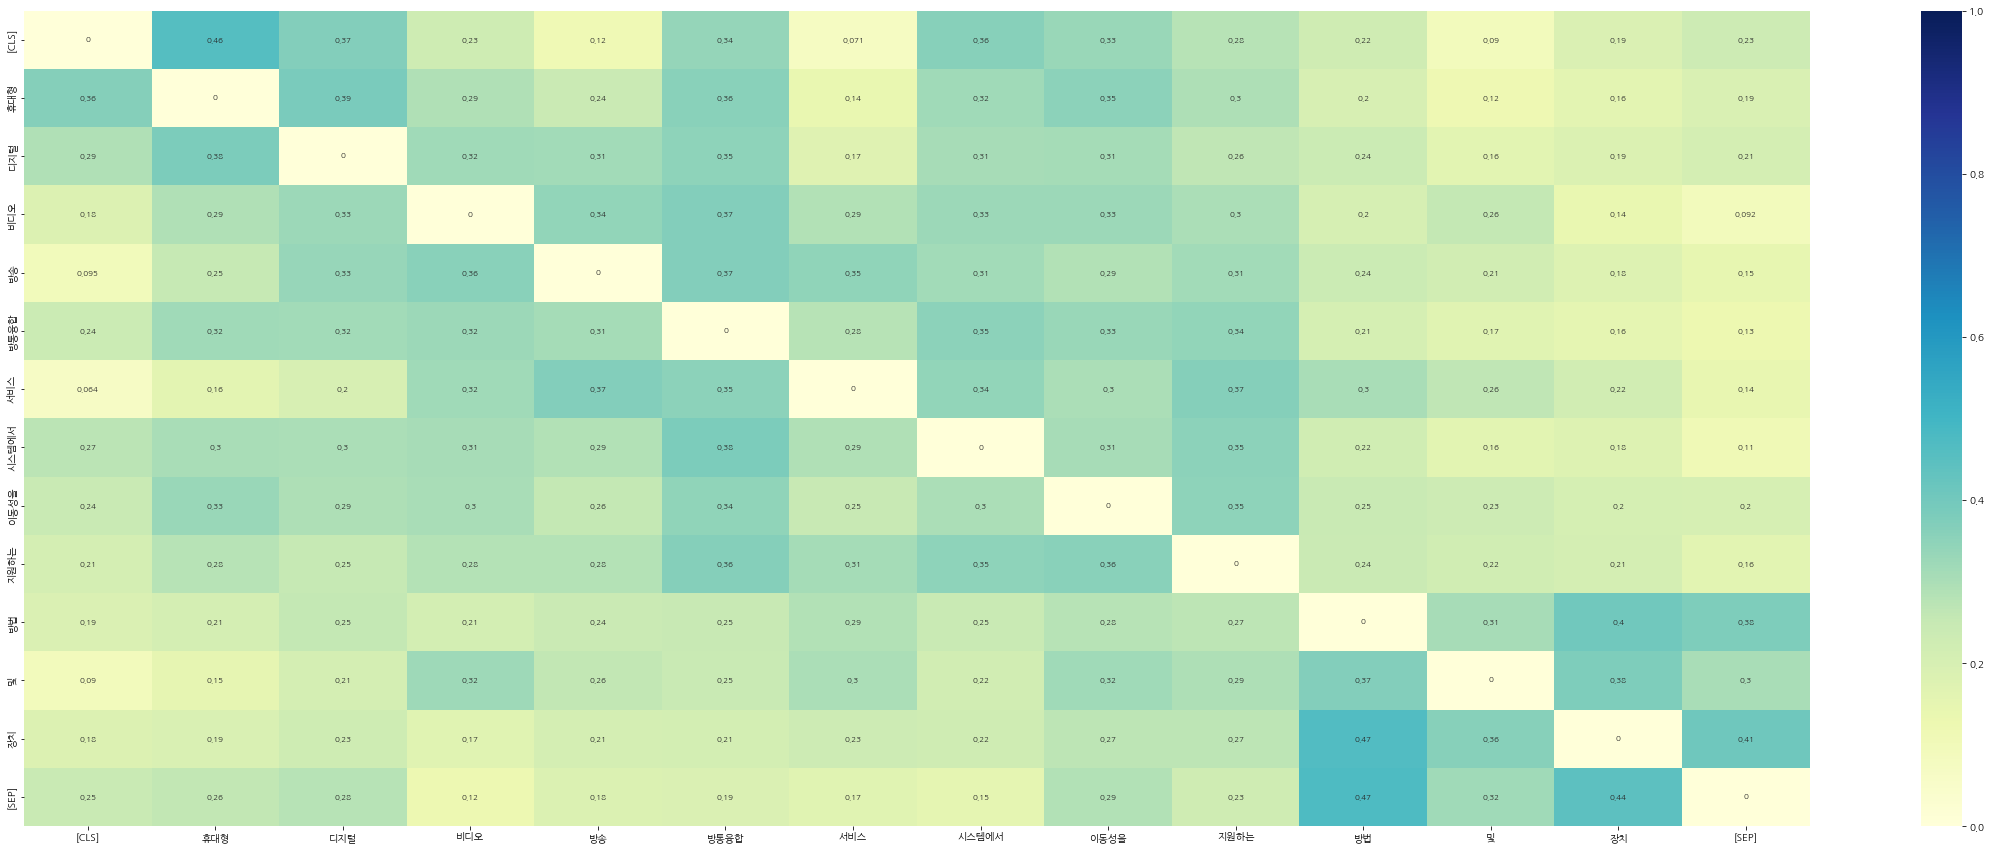

In [63]:
tok_sim1 = np.zeros((len(tok1), len(tok1)))
for i, w in enumerate(tok1):
    for j, w1 in enumerate(tok1):
        # print(cosine_similarity([wv_model.wv[w]], [wv_model.wv[w1]]))
        if i != j:
            tok_sim1[i][j] = cosine_similarity([wv_model1.wv[w]], [wv_model1.wv[w1]])[0][0]
tok_sim1 = normalize(tok_sim1, axis=1, norm='l2')
# tok_sim1 = normalize(tok_sim1, axis=1, norm='max')
fig, axes = plt.subplots(1, 1, figsize = (40,15))
sns.heatmap(tok_sim1, 
            vmin = 0, vmax = 1, xticklabels= tok1, yticklabels = tok1, annot=True, annot_kws={'size':8}, cmap='YlGnBu')
# sns.heatmap(finetuned_avg_attention, ax = axes[1], 
            # vmin = 0, vmax = 1, xticklabels= tok, yticklabels = tok, annot=True, annot_kws={'size':8}, cmap='YlGnBu')